In [1]:
import os
from typing import List
import json

import requests as requests
from typing import Union

from web3 import Web3, HTTPProvider

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
web3 = Web3(HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [4]:
def alchemy_asset_transfers(
        from_address: str,
        to_address: str,
        from_block: Union[int, str],
        to_block: Union[int, str] = 'latest',
        page_key: str = None
):
    if not to_block == 'latest':
        to_block = hex(to_block)

    parameters = {
        "fromBlock": hex(from_block),
        "toBlock": to_block,
        "fromAddress": from_address,
        "toAddress": to_address
    }

    if not from_address:
        parameters.pop('fromAddress')
    if not to_address:
        parameters.pop('toAddress')

    if page_key:
        parameters['pageKey'] = page_key

    response_post = requests.post(
        "https://eth-mainnet.alchemyapi.io/v2/"
        + os.environ["ALCHEMY_API_KEY"],
        json={
            "jsonrpc": "2.0",
            "id": 0,
            "method": "alchemy_getAssetTransfers",
            "params": [parameters]
        },
    )

    response_json = response_post.json()
    return response_json

def get_lp_swaps(
        from_address: str,
        to_address: str,
        from_block: Union[int, str],
        to_block: Union[int, str]
) -> List:

    page_key = None
    all_txes = []
    while True:
        response = alchemy_asset_transfers(
            from_address=from_address,
            to_address=to_address,
            from_block=from_block,
            to_block=to_block,
            page_key=page_key
        )
        transactions = response["result"]["transfers"]
        all_txes.extend(transactions)
        if not 'pageKey' in response['result'].keys():
            break
        page_key = response['result']['pageKey']

    return all_txes

In [5]:
pool_addr = "0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7"
pool_token_addr = "0x6c3f90f043a72fa612cbac8115ee7e52bde6e490"
with open("./3pool.json", 'r') as f:
    abi = json.load(f)
contract = web3.eth.contract(address=pool_addr, abi=abi)

In [6]:
fraction_fee = 0.03 / 100

Query Subgraph:

In [125]:
url = "https://api.thegraph.com/subgraphs/name/convex-community/crv-emissions"
# needs pool token addr and not pool addr:
query = '''
{
  poolSnapshots (
    where:{
      pool: "0x6c3f90f043a72fa612cbac8115ee7e52bde6e490"
    }
  )
  {
    fees
    block
  }
}
'''
r = requests.post(url, json={'query': query})
dict_response= dict(r.json())
df_subgraph_pool_data = pd.DataFrame(dict_response['data']['poolSnapshots'])
df_subgraph_pool_data['block'] = df_subgraph_pool_data.block.astype(int)
df_subgraph_pool_data['fees'] = df_subgraph_pool_data.fees.astype(float)
df_subgraph_pool_data.index = df_subgraph_pool_data.block
df_subgraph_pool_data

,block,fees
block,,
12694121,12694121,0.000000
12739134,12739134,308855.683862
12786681,12786681,251716.971672
12832295,12832295,249842.635058
12874992,12874992,212662.077887
12917964,12917964,267423.781679
12961965,12961965,352703.620124
13007147,13007147,316828.648514
13052446,13052446,292120.571555


In [127]:
blocks = list([int(i) for i in df_subgraph_pool_data.block.values])

In [111]:
block_ranges = list(zip(blocks, blocks[1:]))

[(12694121, 12739134),
 (12739134, 12786681),
 (12786681, 12832295),
 (12832295, 12874992),
 (12874992, 12917964),
 (12917964, 12961965),
 (12961965, 13007147),
 (13007147, 13052446),
 (13052446, 13097719),
 (13097719, 13142950),
 (13142950, 13189474),
 (13189474, 13233504),
 (13233504, 13279324),
 (13279324, 13324114),
 (13324114, 13368595),
 (13368595, 13413314),
 (13413314, 13458926),
 (13458926, 13509655),
 (13509655, 13549403),
 (13549403, 13592432)]

In [112]:
def get_decimal_from_coin_id(id: int) -> float:
    decimals = 1e-18
    if id != 0:
        decimals = 1e-6
    return decimals

In [113]:
fees_for_range = []
for (block_start, block_end) in block_ranges:

    # swaps:
    event_filter = contract.events.TokenExchange.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    token_exchange = event_filter.get_all_entries()
    token_exchange_fees = 0
    for event in token_exchange:
        bought_coin_id = event['args']['bought_id']
        sold_coin_id = event['args']['sold_id']

        bought_coins = event['args']['tokens_bought'] * get_decimal_from_coin_id(bought_coin_id)
        sold_coins = event['args']['tokens_sold'] * get_decimal_from_coin_id(sold_coin_id)

        # rough estimate of fees: difference between bought and sold coins
        token_exchange_fees += abs(bought_coins - sold_coins)

    # add liquidity events
    event_filter = contract.events.AddLiquidity.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    add_liquidity = event_filter.get_all_entries()
    add_liquidity_fees = 0
    for event in add_liquidity:
        fees = event['args']['fees']
        add_liquidity_fees += fees[0] * 1e-18 + 1e-6 * (fees[1] + fees[2])

    # remove liquidity imbalanced:
    event_filter = contract.events.RemoveLiquidityImbalance.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    remove_liquidity_imbalanced = event_filter.get_all_entries()
    remove_liquidity_imbalanced_fees = 0
    for event in remove_liquidity_imbalanced:
        fees = event['args']['fees']
        remove_liquidity_imbalanced_fees += fees[0] * 1e-18 + 1e-6 * (fees[1] + fees[2])

    # remove liquidity one:
    event_filter = contract.events.RemoveLiquidityOne.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    remove_liquidity_one = event_filter.get_all_entries()
    remove_liquidity_one_fees = 0
    for event in remove_liquidity_one:
        coin_amount = event['args']['coin_amount']
        # the event does not give us the coin index. so we make up some guess on what it
        # could be based on number of digits: if less than, say, 1e14, then it is
        # most likely usdc or usdt: hence decimals must be 1e-6

        # for remove liquidity one: only half of 0.03 is charged: check michael's response
        # on curve fi telegram
        fees = 0.5 * fraction_fee * coin_amount * 1e-6
        if fees > 1e5: # fees too high
            fees = 0.5 * fraction_fee * coin_amount * 1e-18

        remove_liquidity_one_fees += fees

    dict_fees = {
        'block_start': block_start,
        'block_end': block_end,
        'add_liquidity': add_liquidity_fees,
        'remove_liquidity_one': remove_liquidity_one_fees,
        'remove_liquidity_imbalanced': remove_liquidity_imbalanced_fees,
        'token_exchange': token_exchange_fees
    }
    fees_for_range.append(dict_fees)


In [114]:
df_fees = pd.DataFrame(fees_for_range)
df_fees

,block_start,block_end,add_liquidity,remove_liquidity_one,remove_liquidity_imbalanced,token_exchange
0,12694121,12739134,87449.444468,77604.620672,5751.629875,241168.337010
1,12739134,12786681,70058.156813,63101.380598,5003.239016,205880.876658
2,12786681,12874992,97155.856510,199461.892372,9343.152927,345164.491535
3,12874992,12917964,46983.550371,55448.343054,5896.772825,340512.725494
4,12917964,12961965,46615.210334,45066.369936,2308.938144,310880.163492
5,12961965,13007147,57767.889245,65662.007064,1788.530504,373634.373657
6,13007147,13052446,51306.496786,115415.484401,1355.856393,276577.435224
7,13052446,13097719,58170.516209,58139.324013,555.616064,222560.848176
8,13097719,13142950,43747.854121,55003.531075,314.939925,109776.451278
9,13142950,13189474,69805.581321,60930.562043,1104.277502,167935.916885


In [135]:
df_fees['total_fees'] = (
        df_fees.add_liquidity +
        df_fees.remove_liquidity_one +
        df_fees.remove_liquidity_imbalanced +
        df_fees.token_exchange
)
df_fees.index = df_fees.block_end
df_fees['subgraph_fees'] = df_subgraph_pool_data[df_subgraph_pool_data.block.isin(df_fees.index)].fees
df_fees

,block_start,block_end,add_liquidity,remove_liquidity_one,remove_liquidity_imbalanced,token_exchange,total_fees,subgraph_fees
block_end,,,,,,,,
12739134,12694121,12739134,87449.444468,77604.620672,5751.629875,241168.337010,411974.032025,308855.683862
12786681,12739134,12786681,70058.156813,63101.380598,5003.239016,205880.876658,344043.653085,251716.971672
12874992,12786681,12874992,97155.856510,199461.892372,9343.152927,345164.491535,651125.393345,212662.077887
12917964,12874992,12917964,46983.550371,55448.343054,5896.772825,340512.725494,448841.391744,267423.781679
12961965,12917964,12961965,46615.210334,45066.369936,2308.938144,310880.163492,404870.681906,352703.620124
13007147,12961965,13007147,57767.889245,65662.007064,1788.530504,373634.373657,498852.800470,316828.648514
13052446,13007147,13052446,51306.496786,115415.484401,1355.856393,276577.435224,444655.272805,292120.571555
13097719,13052446,13097719,58170.516209,58139.324013,555.616064,222560.848176,339426.304462,254498.856534
13142950,13097719,13142950,43747.854121,55003.531075,314.939925,109776.451278,208842.776399,189925.659310


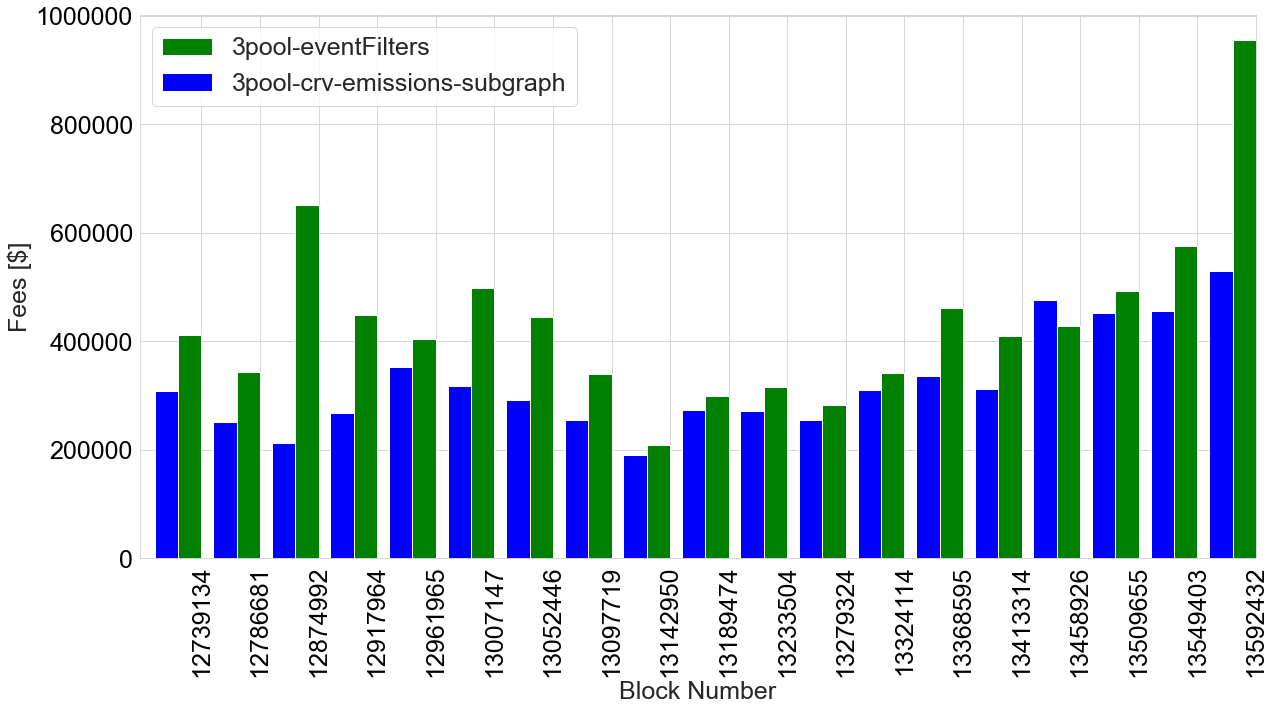

In [137]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))

df_fees['total_fees'].plot(
    color='green',
    kind='bar',
    label='3pool-eventFilters',
    width=0.4,
    position=1,
)

df_fees['subgraph_fees'].plot(
    kind='bar',
    ax=ax,
    color='blue',
    width=0.4,
    position=2,
    label='3pool-crv-emissions-subgraph'
)

ax.set_ylabel("Fees [$]", fontsize=25)
ax.set_xlabel("Block Number", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.legend(fontsize=25);